<a href="https://colab.research.google.com/github/dagyeom23658/project_dayeom_chatbot/blob/main/%EC%B1%97%EB%B4%87%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_%EB%AA%A8%EB%8D%B8%EC%A0%80%EC%9E%A5_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# 트렌스포머



## 멀티헤드어텐션 구현

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

## 인코더 설계
- 멀티 헤드 어텐션에 두번째 서브층인 포지션 와이즈 피드 포워드 신경망을 추가하여 인코더 클래스를 설계

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm


## 포지션 임베딩
- 포지셔널 인코딩을 사용하였지만, 이번에는 위치 정보 자체를 학습을 하도록 하는 포지션 임베딩이라는 방법을 사용
- 포지션 임베딩은 임베딩 층(Embedding layer)를 사용하되, 위치 벡터를 학습하도록 하므로 임베딩 층의 첫번째 인자로 단어 집합의 크기가 아니라 문장의 최대 길이를 넣어줍니다.

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
# pip install konlpy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

import re
from konlpy.tag import Okt
from tqdm import tqdm  #상태진행률 표시
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/프로젝트1/감성대화말뭉치(최종데이터)_Training.xlsx')  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
train_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [ ]:
val_data = pd.read_excel('/content/drive/MyDrive/프로젝트1/감성대화말뭉치(최종데이터)_Validation.xlsx')  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
val_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN


In [ ]:
df=pd.concat([train_data, val_data])

In [ ]:
df.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN


In [ ]:
df.isnull().sum()

번호            0
연령            0
성별            0
상황키워드         0
신체질환          0
감정_대분류        0
감정_소분류        0
사람문장1         0
시스템응답1        0
사람문장2         0
시스템응답2        0
사람문장3     11076
시스템응답3    11076
사람문장4     44386
시스템응답4    44511
dtype: int64

In [ ]:
stop_word = pd.read_excel('/content/drive/MyDrive/프로젝트1/stop_words.xlsx',header=None) 

In [ ]:
stop_words=set(stop_word.iloc[:,0].values.tolist())
stop_words

{',',
 '.',
 '가',
 '가지',
 '같',
 '개',
 '것',
 '경우',
 '그',
 '그것',
 '그녀',
 '그러',
 '그러나',
 '그런',
 '그렇',
 '그리고',
 '나',
 '나오',
 '내',
 '년',
 '놓',
 '다른',
 '다시',
 '대하',
 '더',
 '데',
 '되',
 '두',
 '들',
 '등',
 '따르',
 '때',
 '때문',
 '또',
 '만들',
 '많',
 '말',
 '말하',
 '명',
 '모르',
 '못하',
 '문제',
 '받',
 '번',
 '보',
 '보이',
 '사람',
 '사실',
 '사회',
 '살',
 '생각',
 '생각하',
 '소리',
 '속',
 '수',
 '시간',
 '시키',
 '싶',
 '씨',
 '아니',
 '안',
 '않',
 '알',
 '앞',
 '어떤',
 '어떻',
 '없',
 '여자',
 '오',
 '우리',
 '원',
 '월',
 '위하',
 '이',
 '이런',
 '이렇',
 '일',
 '있',
 '자신',
 '잘',
 '적',
 '전',
 '점',
 '정도',
 '좀',
 '좋',
 '주',
 '중',
 '지',
 '지금',
 '집',
 '크',
 '통하',
 '하',
 '하나',
 '한'}

# 데이터에 대한 이해

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [ ]:
df['번호']=df['번호'].astype('str')

# 앞뒤 공백 처리
df=df.apply(lambda x: x.str.strip() , axis = 1)  #https://www.delftstack.com/ko/howto/python-pandas/difference-between-pandas-apply-map-and-applymap/

In [ ]:
feel_bic_class = df['감정_대분류'].unique()

# 감성 레이블 만들기(숫자로 매핑)

In [ ]:
# 숫자로 감정을 찾을 수 레이블 만들기.
i = 0
feel_bic_dic= {}
for feel in feel_bic_class:
    feel_bic_dic[feel] = i
    i+=1
feel_bic_dic

{'기쁨': 0, '당황': 2, '분노': 4, '불안': 1, '상처': 5, '슬픔': 3}

In [ ]:
i = 0
feel_bic_dic_reverse= {}
for feel in feel_bic_class:
    feel_bic_dic_reverse[i] = feel
    i+=1
feel_bic_dic_reverse

{0: '기쁨', 1: '불안', 2: '당황', 3: '슬픔', 4: '분노', 5: '상처'}

In [ ]:
df_label = []
for feel in df['감정_대분류']:
    df_label.append(feel_bic_dic[feel])

# 토큰화

In [ ]:
from konlpy.tag import Okt
from konlpy.tag import Kkma
import re

In [ ]:
okt=Okt()
X_train = []
for sentence in df['사람문장1']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_words] # 불용어 제거
    X_train.append(stopwords_removed_sentence)
print(X_train[:3])

[['아내', '드디어', '출산', '하다', '되어다', '정말', '신'], ['당뇨', '랑', '합병증', '에', '먹다', '하다', '약', '열', '넘어가다', '스트레스', '야'], ['고등학교', '에', '올라오다', '중학교', '보다', '수업', '갑자기', '어려워지다', '당황', '스럽다']]


### 정수인코딩

- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
word_index = tokenizer.word_index
print(tokenizer.word_index)   # 여기서 oov는 어떻게 되는거지?

# 0은 패딩을 위해 비워둠

{'하다': 1, '을': 2, '에': 3, '를': 4, '너무': 5, '친구': 6, '있다': 7, '같다': 8, '는': 9, '에서': 10, '도': 11, '없다': 12, '보다': 13, '않다': 14, '은': 15, '좋다': 16, '못': 17, '받다': 18, '되다': 19, '이야': 20, '만': 21, '에게': 22, '들다': 23, '돼다': 24, '회사': 25, '오늘': 26, '요즘': 27, '으로': 28, '돈': 29, '정말': 30, '게': 31, '의': 32, '로': 33, '나르다': 34, '아내': 35, '싶다': 36, '걱정': 37, '스럽다': 38, '가다': 39, '한테': 40, '하고': 41, '남편': 42, '이번': 43, '힘들다': 44, '모르다': 45, '?': 46, '고': 47, '나다': 48, '결혼': 49, '자다': 50, '슬프다': 51, '화가': 52, '다': 53, '많이': 54, '직장': 55, '오다': 56, '과': 57, '아프다': 58, '기분': 59, '거': 60, '!': 61, '마음': 62, '아들': 63, '나오다': 64, '되어다': 65, '엄마': 66, '준비': 67, '당황': 68, '불안하다': 69, '많다': 70, '당하다': 71, '나이': 72, '건강': 73, '해': 74, '랑': 75, '병원': 76, '먹다': 77, '어떻다': 78, '와': 79, '자식': 80, '가족': 81, '이제': 82, '학교': 83, '취업': 84, '부모님': 85, '기쁘다': 86, '난': 87, '일이': 88, '자꾸': 89, '인데': 90, '날': 91, '야': 92, '주다': 93, '아이': 94, '속상하다': 95, '딸': 96, '노후': 97, '걸': 98, '혼자': 99, '은퇴': 100, '다니다': 101, '짜증':

In [ ]:
vocab_size = len(tokenizer.word_index) +1     # 단어집합의 크기

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)

In [ ]:
print(X_train[:3])
# 각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인할 수 있습니다.

[[35, 216, 303, 1, 65, 30, 645], [373, 75, 1092, 3, 77, 1, 278, 650, 1288, 116, 92], [576, 3, 1455, 1374, 13, 592, 108, 1064, 68, 38]]


In [ ]:
# 훈련 데이터와 테스트 데이터의 문장과 레이블을 각각 저장합니다.
y_train = np.array(df_label)

### 패딩

문장의 최대 길이 : 49
문장의 평균 길이 : 10.832206742159142


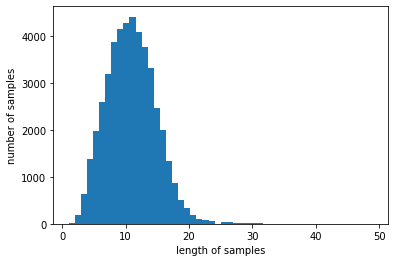

In [ ]:
print('문장의 최대 길이 :',max(len(text) for text in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(text) for text in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 전체 데이터의 길이 분포는 대체적으로 약 9내외의 길이를 가지는 것을 볼 수 있습니다. 

In [ ]:
# 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [ ]:
# 위의 분포 그래프를 봤을 때, max_len = 25이 적당할 것 같습니다. 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인해봅시다. 채팅 특성상 엄청 긴 문장이 포함되지 않으므로, 최대길이로 모든 데이터를 패딩하면 됨. --> 그러나 별 차이 없었다고 한다.
max_len =  25       # 18 에서 99%
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 99.71527309874155


In [ ]:
# 전체 훈련 데이터 중 약 99%의 리뷰가 18이하의 길이를 가지는 것을 확인했습니다. 모든 샘플의 길이를 18으로 맞추겠습니다.
X_train = pad_sequences(X_train, maxlen=max_len)

In [ ]:
# 훈련용, 테스트용 뉴스 기사 데이터의 레이블에 원-핫 인코딩을 합니다.
y_train = to_categorical(y_train)

In [ ]:
print('전체 데이터의 크기(shape):', X_train.shape)
print('레이블 데이터의 크기(shape):', y_train.shape)

전체 데이터의 크기(shape): (46009, 25)
레이블 데이터의 크기(shape): (46009, 6)


In [ ]:
print(X_train[0])
print(y_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  35 216 303   1  65  30 645]
[1. 0. 0. 0. 0. 0.]


In [ ]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(6, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)  # 데이터 크기를 늘이니까 정확도가 조금 더 개선된다. 에포크수가 더할수록 과적합되는 건 마찬가지.

Epoch 1/2
1151/1151 [==============================] - 29s 20ms/step - loss: 1.3837 - acc: 0.4530 - val_loss: 1.1198 - val_acc: 0.5950
Epoch 2/2
1151/1151 [==============================] - 23s 20ms/step - loss: 1.0600 - acc: 0.6269 - val_loss: 1.0904 - val_acc: 0.6048


In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 25)]              0         
                                                                 
 token_and_position_embeddin  (None, 25, 32)           324320    
 g_6 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_6 (Transf  (None, 25, 32)           6464      
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_4   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_18 (Dropout)        (None, 32)                0   

In [ ]:
# 모델저장

In [ ]:
# model.save('feel_analysis_model.h5')   # 에러 : https://lsjsj92.tistory.com/598, https://stackoverflow.com/questions/58678836/notimplementederror-layers-with-arguments-in-init-must-override-get-conf
# 커스텀된 트랜스포머라 저장도 로드도 어려웠다. 
# 가중치 저장 후 로드 https://tykimos.github.io/2017/06/10/Model_Save_Load/

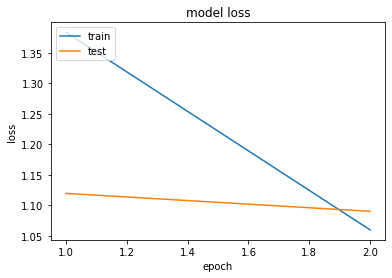

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-0py_mwsk
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-0py_mwsk
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=76eee3446dd0787a80e3aec5c89b87b1ae245733141f251fde61e81a97266d80
  Stored in directory: /tmp/pip-ephem-wheel-cache-kowhb71d/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


In [ ]:
# 예측해보기
from hanspell import spell_checker
def sentiment_predict(new_sentence):
  spelled_sent = spell_checker.check(new_sentence)    # 챗봇에 단어를 입력할 때는 비문법이 많으므로 문법을 맞춰주고 띄어쓰기를 시켜준다. 이걸 추가하니까 성능이 훨씬 좋아졌다.
  hanspell_sent = spelled_sent.checked
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', hanspell_sent)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_words] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = model.predict(pad_new) # 예측
#   print(score[0, score.argmax()])
  return feel_bic_dic_reverse[score.argmax()]

In [ ]:
sentiment_predict('상장을 받았어')

'기쁨'

In [ ]:
sentiment_predict('오늘 학교에서 상을 받았어')  # 상을 구별못함. 이러면 곤란...

'기쁨'

In [ ]:
sentiment_predict('ㅋㅋㅋㅋㅋㅋ 오늘 학교에서 상받아떵') 

'슬픔'

In [ ]:
sentiment_predict('ㅋㅋㅋㅋㅋㅋ 오늘 학교에서 상받아서 너무 기분좋아')  # 직접적으로 기분을 말해주면 구분을 하는데, 상황에 따른 판별력은 떨어진다. 

'기쁨'

In [ ]:
sentiment_predict('아빠한테 맞았어')   # 누가봐도 상처인 건 구별한다. 

'상처'

In [ ]:
sentiment_predict('남자친구가 샤넬백 사줌')  

'기쁨'

In [ ]:
sentiment_predict('남자친구한테 샤넬백 사줌') 

'기쁨'

In [ ]:
sentiment_predict('아프리카 난민에게 기부함')

'기쁨'

In [ ]:
sentiment_predict('카리나는 너무 예쁘다')  # 나름 일리있는 것 같기도...ㅋㅋㅋ

'상처'

In [ ]:
sentiment_predict('난 너무 못생겼어') 

'슬픔'

In [ ]:
# 임베딩이나, 불용어 처리 같은 것이 .. 큰 차이가 없는 것 같다. 그것보다는 하이퍼파라미터를 조절하는게 정확도 개선에 나을 것 같기도 하고...
# 사실 잘 모르겠다. 
# 우리나라 말은 특히, 한 단어안에 여러가지 중의적 의미를 내포하고 있는 경우가 많아서 정확도가 더 떨어지는 것 같기도 하다. 

# 한국어 챗봇에서 가장 중요한 건, 맞춤법 검사기를 꼭 넣어야 한다는 것이다. 